## Imports

In [1]:
import re
import os
import subprocess

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from vis import *

## Utils

In [2]:
def parse_performance_data(text):
    pattern = re.compile(
        r"Algorithm:\s*(?P<Algorithm>\S+)\s*"
        r"Instance:\s*(?P<Instance>\S+)\s*"
        r"Initial Score:\s*(?P<Initial_Score>\d+)\s*"
        r"Score:\s*(?P<Score>\d+)\s*"
        r"Number\s*of\s*Evaluations:\s*(?P<Number_of_Evaluations>\d+)\s*"
        r"Number\s*of\s*Performed\s*Moves:\s*(?P<Number_of_Performed_Moves>\d+)\s*"
        r"Number\s*of\s*Best\s*Solution\s*Updates:\s*(?P<Number_of_Best_Solution_Updates>\d+)\s*"
        r"Solution:\s*(?P<Solution>[\d\s]+)\s*"
        r"Optimal\s*Score:\s*(?P<Optimal_Score>\d+)\s*"
        r"Optimal\s*Solution:\s*(?P<Optimal_Solution>[\d\s]+)"
    )
    
    rows = []
    for match in pattern.finditer(text):
        row = match.groupdict()
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    numerical_cols = ['Initial_Score', 'Score', 'Number_of_Evaluations', 'Number_of_Performed_Moves', 'Number_of_Best_Solution_Updates', 'Optimal_Score']
    df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric)
    
    return df

def parse_runtime_data(text):
    pattern = re.compile(
        r"Algorithm:\s*(?P<Algorithm>\S+)\s*"
        r"Instance:\s*(?P<Instance>\S+)\s*"
        r"Runtime:\s*(?P<Runtime>\S+)\s*"
    )
    
    rows = []
    for match in pattern.finditer(text):
        row = match.groupdict()
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    numerical_cols = ['Runtime']
    df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric)
    
    return df

## Define variables
### Optional - run scripts from python

In [3]:
performance_file = 'results/performance_results.txt'
runtime_file = 'results/runtime_results.txt'

sa_ts_performance_file = 'results/sa_ts_performance_results.txt'
sa_ts_runtime_file = 'results/sa_ts_runtime_results.txt'

selected_instances = ["chr22a", "tai60a"]

In [4]:
# # Names of instances ordered by instance size
# instance_names_ordered = ["wil100", "lipa80a", "tai60a", "kra30a", "bur26a", "bur26b", "chr22a", "chr20c", "had14"][::-1]

# RANDOMRUNTIMES = {'bur26a': 3123592.0,
#                 'bur26b': 2541337.0,
#                 'chr20c': 647929.9,
#                 'chr22a': 667595.9,
#                 'had14': 206135.0,
#                 'kra30a': 2795186.0,
#                 'lipa80a': 86358480.0,
#                 'tai60a': 29373680.0,
#                 'wil100': 1075083000.0}

# algorithm_colors = {
#     "greedyLS": "#e41a1c",
#     "steepestLS": "#377eb8",
#     "heuristic": "#4daf4a",
#     "antiheuristic": "#a65628",
#     "random": "#ff7f00",
#     "randomwalk": "#fdb462",
#     "randomsearch": "#984ea3",
#     "iterativeImprovement": "#999999",
#     "simulatedAnnealing": "#fb9a99",
#     "tabooSearch": "#b15928"
# }

In [5]:
# run_bio_alg("data/qap/", "runtime_results.txt", "performance_results.txt", "both", instance_names_ordered, RANDOMRUNTIME)

## Read Data

In [6]:
with open(runtime_file, 'r') as file:
    data = file.read()
    
df_runtime = parse_runtime_data(data)

with open(sa_ts_runtime_file, 'r') as file:
    data = file.read()

df_runtime = pd.concat([parse_runtime_data(data), df_runtime])

In [7]:
df_runtime.head()

,Algorithm,Instance,Runtime
0,simulatedAnnealing,wil100,2.793660e+09
1,simulatedAnnealing,wil100,2.637900e+09
2,simulatedAnnealing,wil100,2.645450e+09
3,simulatedAnnealing,wil100,2.767640e+09
4,simulatedAnnealing,wil100,2.876830e+09


In [8]:
# RANDOMRUNTIMES = {}
# for i, row in df_runtime[df_runtime.Algorithm == "greedyLS"].groupby(["Algorithm", "Instance"])["Runtime"].agg(["mean", "std"]).reset_index().iterrows():
#     RANDOMRUNTIMES[row.Instance] = row[2]
# RANDOMRUNTIMES

In [9]:
with open(performance_file, 'r') as file:
    data = file.read()

df_performance = parse_performance_data(data)
with open(sa_ts_performance_file, 'r') as file:
    data = file.read()

df_performance = pd.concat([parse_performance_data(data), df_performance])
df_performance.Algorithm = df_performance.Algorithm.apply(lambda x: x[1:] if (x.endswith(("LS", "Improvement")) or \
                                                                              x.startswith(("rsimulated", "rtaboo"))) else x)

# Analysis

### Problem Description
#### 8 Selected instances:

Selected with the intent of checking various sized instances with some repetitions of instance class to verify consistency
***"wil100", "lipa80a", "lipa80b", "tai60a", "kra30a", "bur26a", "bur26b", "chr22a", "had14"***

#### Neighborhood used: pair swap
#### Neighborhood size: n(n-1)/2 

## Runtime

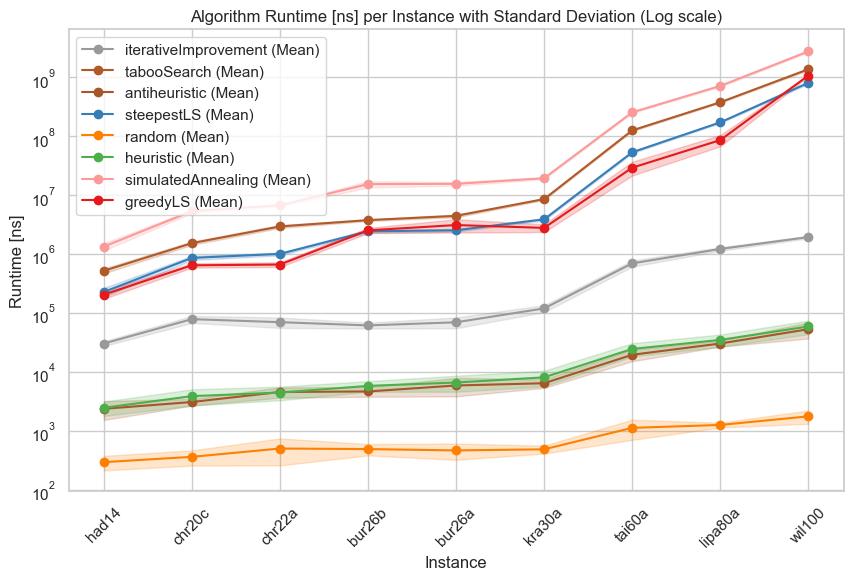

In [10]:
summary = df_runtime.groupby(["Algorithm", "Instance"])["Runtime"].agg(["mean", "std"]).reset_index()
summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")
plot_algorithms("SA_TS_Algrotihms_Runtime_Log.pdf", summary, title="Runtime [ns]", log_scale=True)

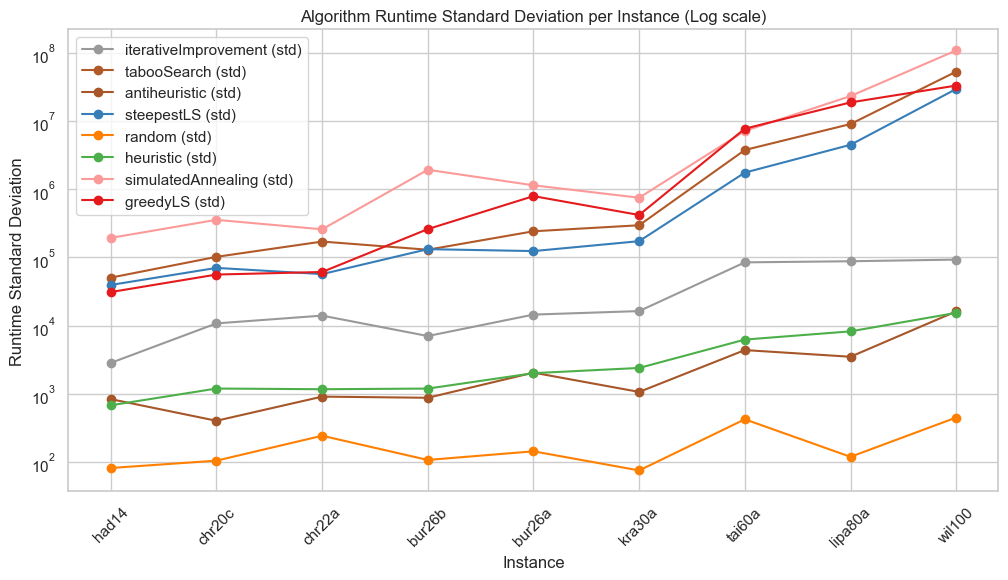

In [11]:
plot_std_line("SA_TS_Algorithm_Runtime_Standard_Deviation.pdf", summary, title="Runtime Standard Deviation", log_scale=True)

In [12]:
# ls_algorithms = summary[summary["Algorithm"].str.contains("LS")]
# plot_algorithms(ls_algorithms, title="Runtime [ns]")

In [13]:
# non_ls_algorithms = summary[~summary["Algorithm"].str.contains("LS")]
# plot_algorithms(non_ls_algorithms, title="Runtime [ns]")

## Quality

In [14]:
df_performance["Solution_Quality"] = (df_performance["Score"] - df_performance["Optimal_Score"]) / df_performance["Optimal_Score"] * 100

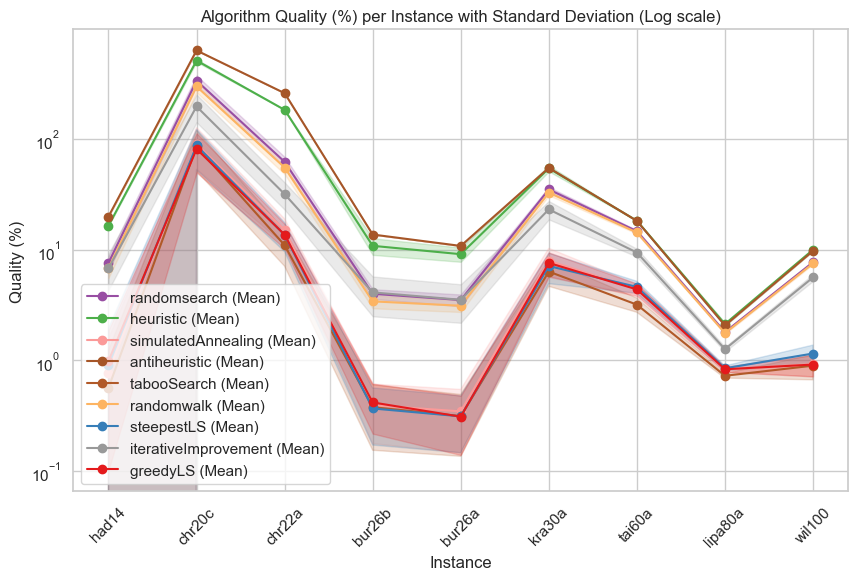

In [15]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Solution_Quality"].agg(["mean", "std"]).reset_index()
summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
# summary = summary[summary.Instance != "chr22a"]
summary = summary.sort_values("Instance")
plot_algorithms("SA_TS_Algorithm_Quality_log.pdf", summary, title="Quality (%)", log_scale=True)

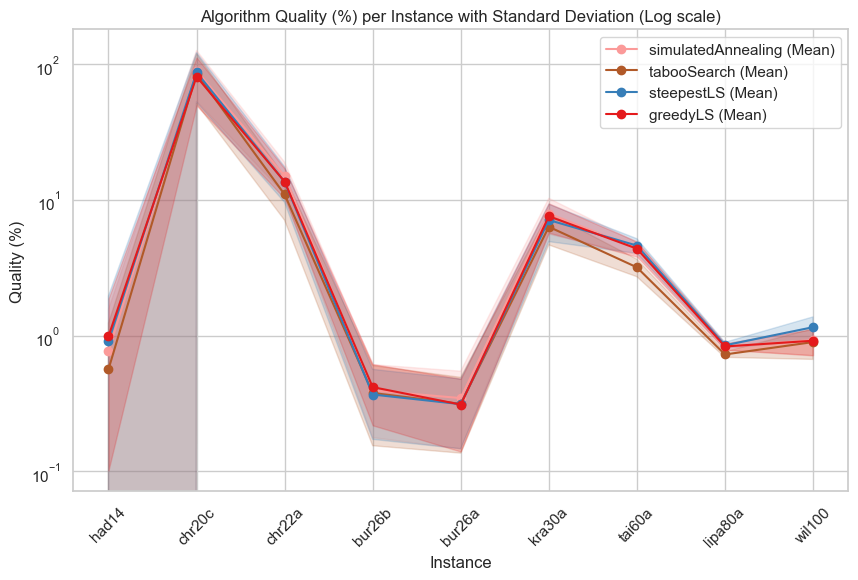

In [16]:
summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary[summary.Algorithm.isin(("greedyLS", "steepestLS", "tabooSearch", "simulatedAnnealing"))]
summary = summary.sort_values("Instance")
plot_algorithms("SA_TS_Algorithm_Quality_log.pdf", summary, title="Quality (%)", log_scale=True)

In [33]:
df_performance[df_performance.Algorithm.isin(("greedyLS", "steepestLS", "tabooSearch", "simulatedAnnealing"))].groupby(["Instance", "Algorithm", "Optimal_Score"])["Score"].agg([max, np.mean, min])

max        mean      min
Instance Algorithm          Optimal_Score                              
bur26a   greedyLS           5426670        5486151  5443527.29  5426670
         simulatedAnnealing 5426670        5498828  5445494.51  5428216
         steepestLS         5426670        5478450  5443647.01  5427110
         tabooSearch        5426670        5474625  5443738.63  5426670
bur26b   greedyLS           3817852        3857478  3833801.96  3817852
         simulatedAnnealing 3817852        3861238  3832915.06  3817852
         steepestLS         3817852        3855861  3831919.73  3817852
         tabooSearch        3817852        3876859  3832302.10  3818477
chr20c   greedyLS           14142            37506    25607.96    16220
         simulatedAnnealing 14142            42624    26856.38    16460
         steepestLS         14142            40058    26490.80    15770
         tabooSearch        14142            37784    26221.56    14142
chr22a   greedyLS           6156              7448     6996.80     6406
         simulatedAnnealing 6156              7722     7081.34     6586
         steepestLS         6156              7548     6992.72     6438
         tabooSearch        6156              7696     6831.76     6342
had14    greedyLS           2724              2872     2750.92     2724
         simulatedAnnealing 2724              2826     2745.12     2724
         steepestLS         2724              2884     2748.70     2724
         tabooSearch        2724              2826     2739.38     2724
kra30a   greedyLS           88900            99520    95644.40    92190
         simulatedAnnealing 88900           102050    95961.30    91170
         steepestLS         88900            99280    95225.00    90620
         tabooSearch        88900            98210    94538.00    91300
lipa80a  greedyLS           253195          255664   255302.86   255053
         simulatedAnnealing 253195          255499   255286.41   255009
         steepestLS         253195          255654   255345.67   255033
         tabooSearch        253195          255237   255035.88   254782
tai60a   greedyLS           7208572        7643832  7524152.38  7426500
         simulatedAnnealing 7208572        7626416  7525845.56  7453190
         steepestLS         7208572        7629298  7541130.44  7457456
         tabooSearch        7208572        7518806  7438462.86  7368958
wil100   greedyLS           273038          276854   275544.00   274320
         simulatedAnnealing 273038          276976   275575.56   274118
         steepestLS         273038          278104   276190.88   274816
         tabooSearch        273038          276960   275487.98   273682

Note: steepest achieves global optimum for had14

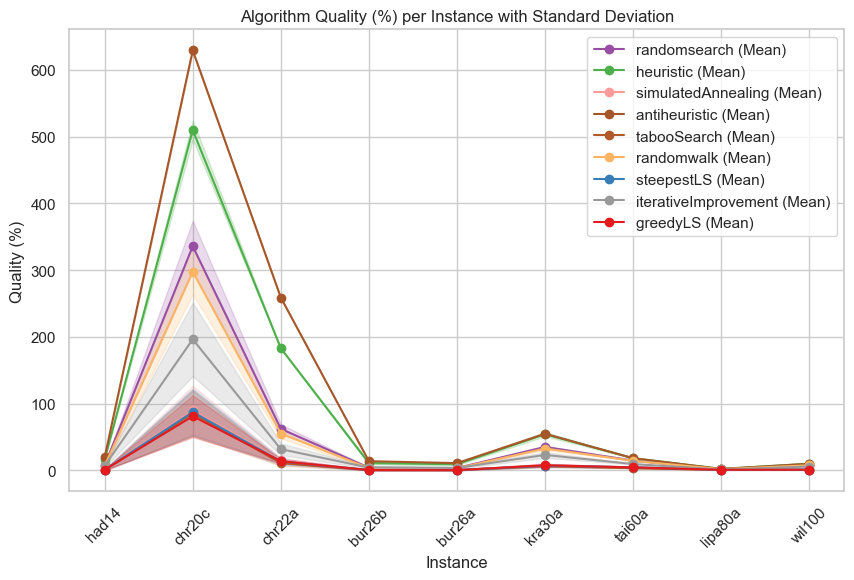

In [18]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Solution_Quality"].agg(["mean", "std"]).reset_index()
summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
# summary = summary[~summary.Instance.str.startswith("chr")]
summary = summary.sort_values("Instance")
plot_algorithms("SA_TS_Algorithm_Quality.pdf", summary, title="Quality (%)", log_scale=False)

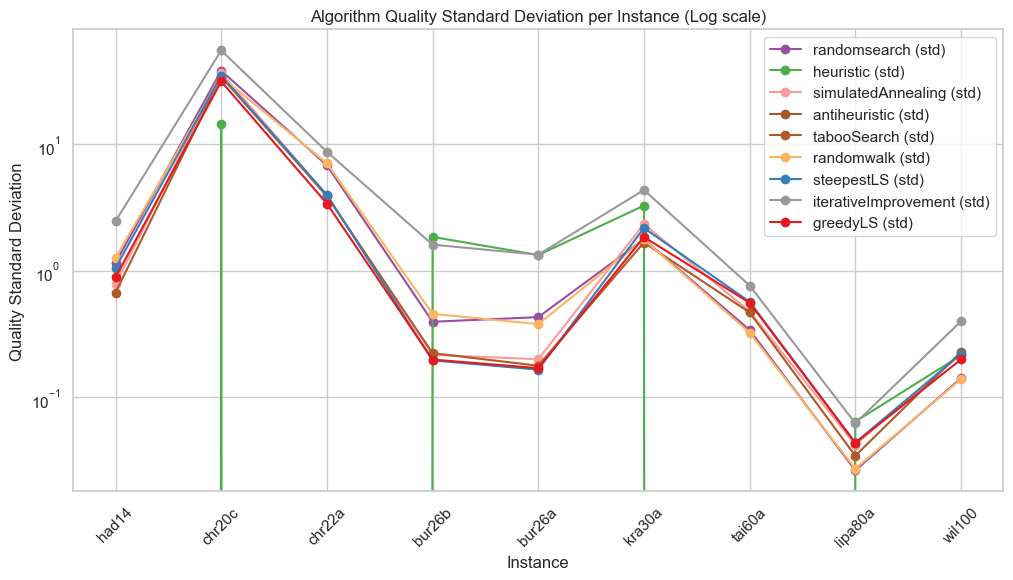

In [19]:
plot_std_line("SA_TS_Algorithm_Quality_Standard_Deviation.pdf", summary, title="Quality Standard Deviation", log_scale=True)

## Efficiency

In [20]:
df_runtime_summary = df_runtime.groupby(["Algorithm", "Instance"]).agg(
    mean_runtime=("Runtime", "mean"),
    std_runtime=("Runtime", "std")
).reset_index()

df_combined = df_performance.merge(df_runtime_summary, on=["Algorithm", "Instance"], how="left")

df_combined["Solution_Quality"] = (df_combined["Score"] - df_combined["Optimal_Score"]) / df_combined["Optimal_Score"] * 100

df_combined.loc[df_combined["Algorithm"].isin(["randomwalk", "randomsearch"]), "mean_runtime"] = df_combined["Instance"].map(RANDOMRUNTIMES)
df_combined.loc[df_combined["Algorithm"].isin(["randomwalk", "randomsearch"]), "std_runtime"] = 0.0

df_combined.head()

,Algorithm,Instance,Initial_Score,Score,Number_of_Evaluations,Number_of_Performed_Moves,Number_of_Best_Solution_Updates,Solution,Optimal_Score,Optimal_Solution,Solution_Quality,mean_runtime,std_runtime
0,simulatedAnnealing,wil100,301684,275622,922555,38597,0,91 65 81 93 6 56 13 77 54 49 35 39 90 11 19 7 ...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,0.946388,2.762754e+09,1.084405e+08
1,simulatedAnnealing,wil100,299910,275288,794159,40353,0,14 70 80 72 62 30 34 23 28 32 0 73 12 57 36 90...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,0.824061,2.762754e+09,1.084405e+08
2,simulatedAnnealing,wil100,300066,274792,685602,45747,0,14 62 8 13 99 73 33 59 56 0 34 42 72 65 10 57 ...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,0.642401,2.762754e+09,1.084405e+08
3,simulatedAnnealing,wil100,298984,275558,528876,47311,0,83 65 77 6 39 71 24 47 54 49 8 57 41 42 96 67 ...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,0.922948,2.762754e+09,1.084405e+08
4,simulatedAnnealing,wil100,300010,275668,1068125,52103,0,32 29 47 49 71 99 59 8 0 14 48 24 50 67 51 94 ...,273038,15 28 100 64 95 88 32 87 30 50 9 10 43 56 78 7...,0.963236,2.762754e+09,1.084405e+08


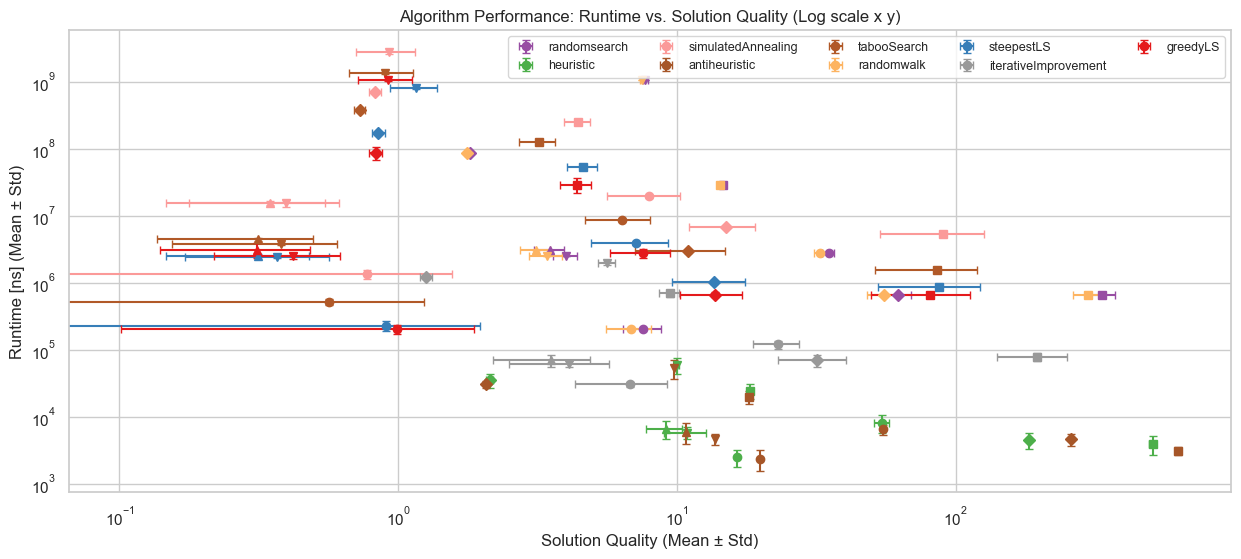

In [21]:
summary = df_combined.groupby(["Algorithm", "Instance"]).agg(
    mean_runtime=("mean_runtime", "mean"),
    std_runtime=("std_runtime", "mean"),
    mean_quality=("Solution_Quality", "mean"),
    std_quality=("Solution_Quality", "std")
).reset_index()

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

non_ls_algorithms = summary[~summary["Algorithm"].str.contains("LS|random")]
ls_algorithms = summary[summary["Algorithm"].str.contains("LS|random")]

plot_efficiency("SA_TS_Runtime_Quality.pdf", summary, show_instances=False, log_scale_x=True, log_scale_y=True)
# plot_efficiency(non_ls_algorithms, show_instances=False, log_scale_x=True, log_scale_y=True)
# plot_efficiency(ls_algorithms, show_instances=False, log_scale_x=True, log_scale_y=True)

## Number of Moves/Evaluations/Best Solution Updates

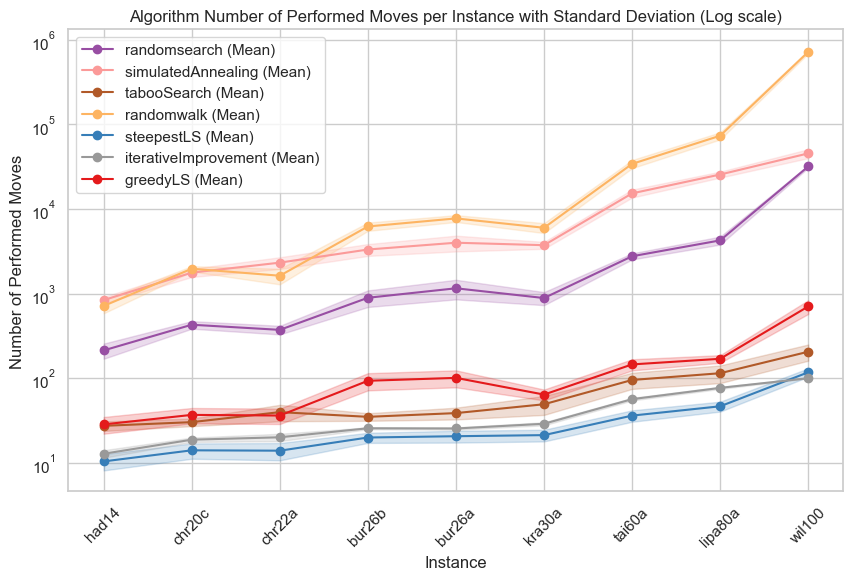

In [22]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Number_of_Performed_Moves"].agg(["mean", "std"]).reset_index()

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

summary = summary[~summary["Algorithm"].str.contains("heuristic")]
plot_algorithms("SA_TS_Performed_Moves.pdf", summary, title="Number of Performed Moves", log_scale=True)

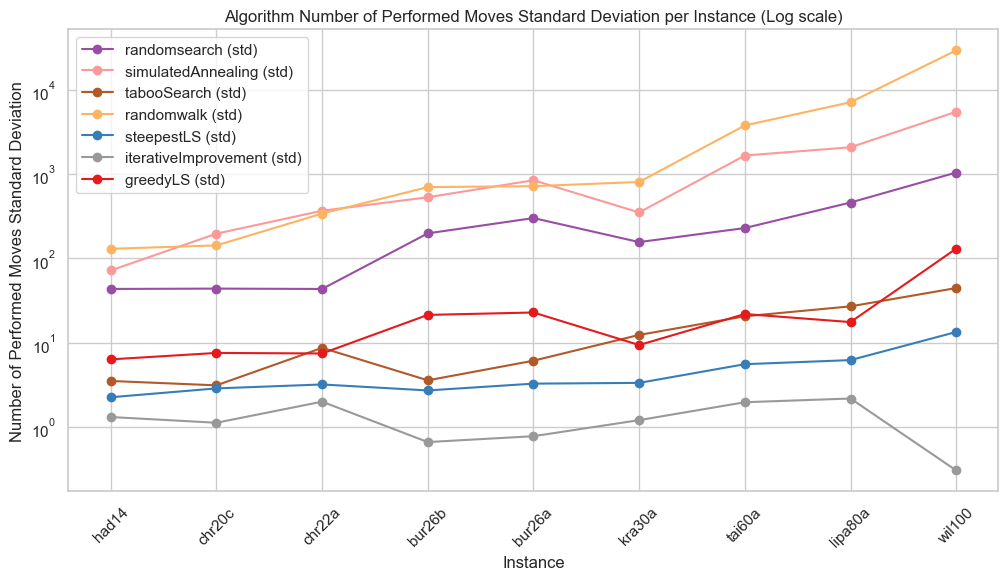

In [23]:
plot_std_line("SA_TS_Number_Moves_Std.pdf", summary, title="Number of Performed Moves Standard Deviation", log_scale=True)

In [24]:
# ls_algorithms = summary[summary["Algorithm"].str.contains("LS")]
# plot_algorithms(ls_algorithms, title="Number of Performed Moves")

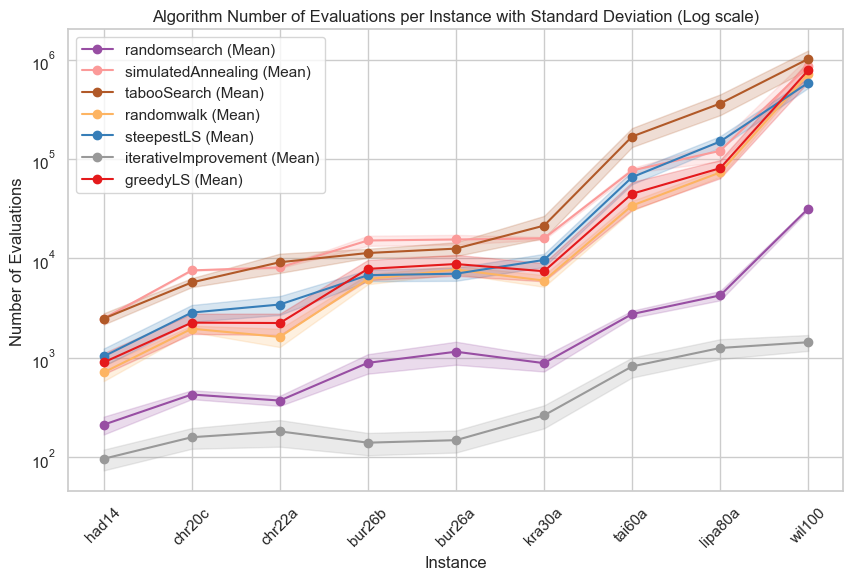

In [25]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Number_of_Evaluations"].agg(["mean", "std"]).reset_index()

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

summary = summary[~summary["Algorithm"].str.contains("heuristic")]
plot_algorithms("SA_TS_Num_Evaluations_Log.pdf", summary, title="Number of Evaluations", log_scale=True)

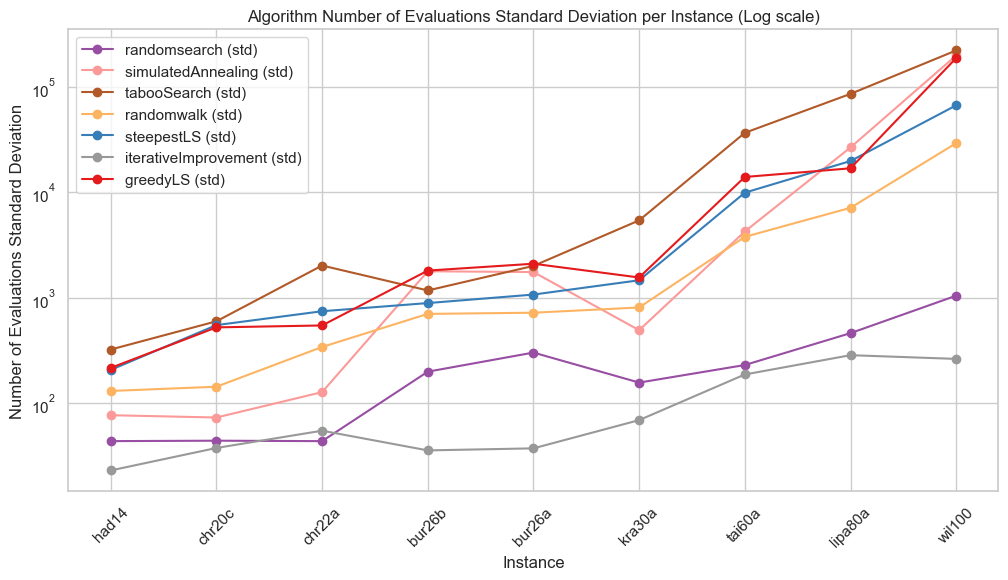

In [26]:
plot_std_line("SA_TS_Num_Evaluations_Log_std.pdf", summary, title="Number of Evaluations Standard Deviation", log_scale=True)

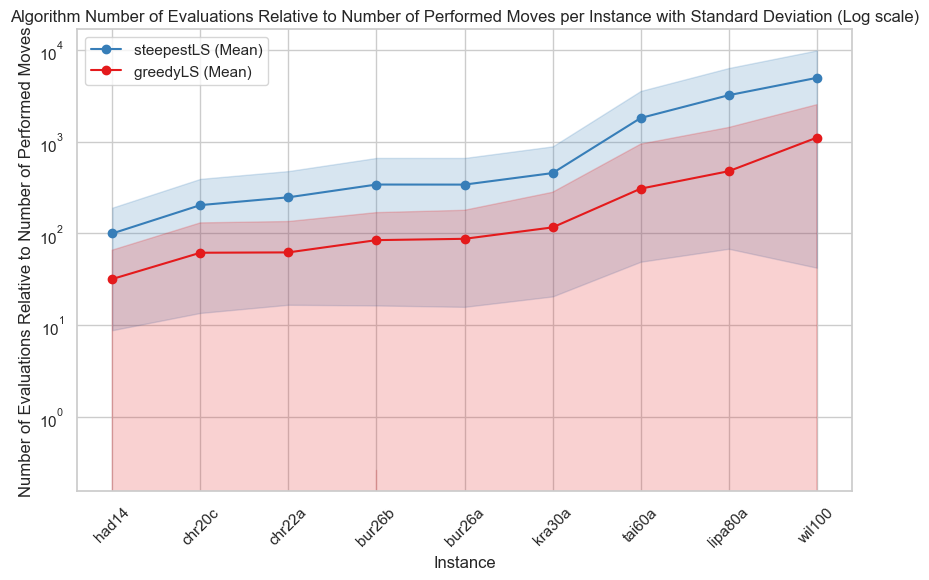

In [27]:
summary = df_performance.groupby(["Algorithm", "Instance"])[["Number_of_Evaluations", "Number_of_Performed_Moves"]].agg(["mean", "std"]).reset_index()
summary.columns = ['_'.join(col).strip('_') for col in summary.columns]

summary["Relative_Evaluations_mean"] = summary["Number_of_Evaluations_mean"] / summary["Number_of_Performed_Moves_mean"]
summary["Relative_Evaluations_std"] = summary["Number_of_Evaluations_std"] / summary["Number_of_Performed_Moves_std"]

summary = summary[["Algorithm", "Instance", "Relative_Evaluations_mean", "Relative_Evaluations_std"]]
summary = summary.rename(columns={"Relative_Evaluations_mean": "mean", "Relative_Evaluations_std": "std"})

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

summary = summary[summary["Algorithm"].str.contains("LS")]

plot_algorithms("SA_TS_Relative_Performed_Moves.pdf", summary, "Number of Evaluations Relative to Number of Performed Moves", log_scale=True)

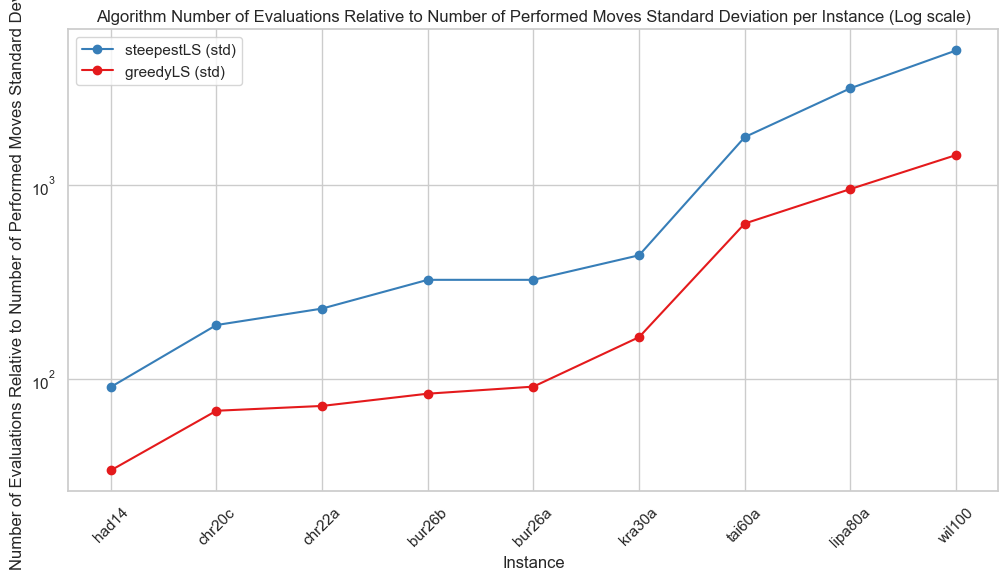

In [28]:
plot_std_line("SA_TS_Relative_Number_Performed_Moves_2.pdf", summary, title="Number of Evaluations Relative to Number of Performed Moves Standard Deviation", log_scale=True)

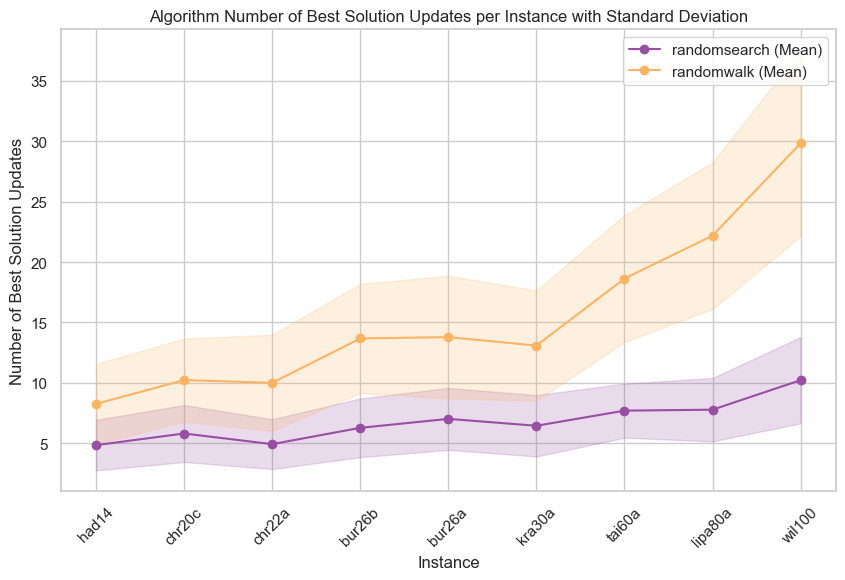

In [29]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Number_of_Best_Solution_Updates"].agg(["mean", "std"]).reset_index()

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")

summary = summary[summary["Algorithm"].str.contains("random")]
plot_algorithms("SA_TS_Best_Solution_Updates.pdf", summary, title="Number of Best Solution Updates", log_scale=False)

C:\Users\barte\AppData\Local\Temp\ipykernel_8724\3522918319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_algs["Rel_Updates"] = random_algs.Number_of_Best_Solution_Updates/random_algs.Number_of_Performed_Moves


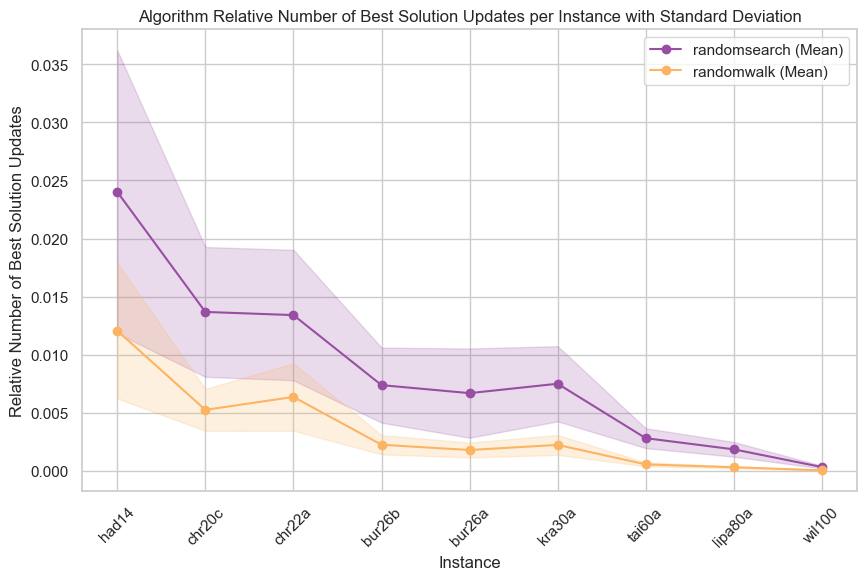

In [30]:
random_algs = df_performance[(df_performance["Algorithm"] == "randomwalk") | (df_performance["Algorithm"] == "randomsearch")]
random_algs["Rel_Updates"] = random_algs.Number_of_Best_Solution_Updates/random_algs.Number_of_Performed_Moves

summary = random_algs.groupby(["Algorithm", "Instance"])["Rel_Updates"].agg(["mean", "std"]).reset_index()

summary["Instance"] = pd.Categorical(summary["Instance"], categories=instance_names_ordered, ordered=True)
summary = summary.sort_values("Instance")
plot_algorithms("SA_TS_Rel_Best_Solution_Updates.pdf", summary, title="Relative Number of Best Solution Updates", log_scale=False)

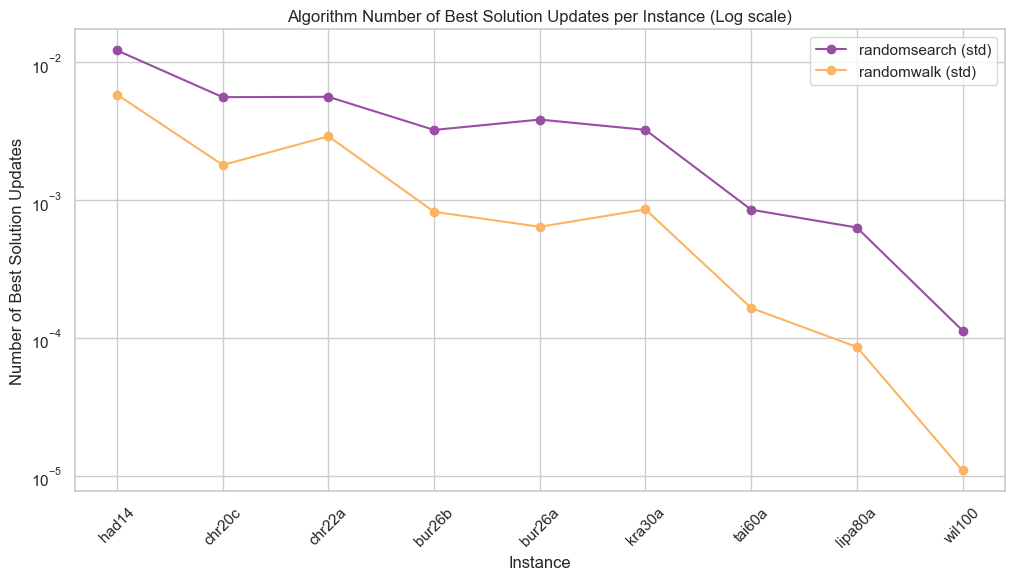

In [31]:
plot_std_line("SA_TS_Best_Solution_Updates_2.pdf", summary, title="Number of Best Solution Updates", log_scale=True)